### A) PCA y clústering con k-means

1.	A partir de la base de datos Iris, con sus cuatro características, obtened los dos primeros componentes principales. Representad gráficamente los puntos de datos a partir de los dos componentes principales obtenidos. Como estamos realizando aprendizaje no supervisado, no es necesario tener en cuenta las etiquetas de clase.

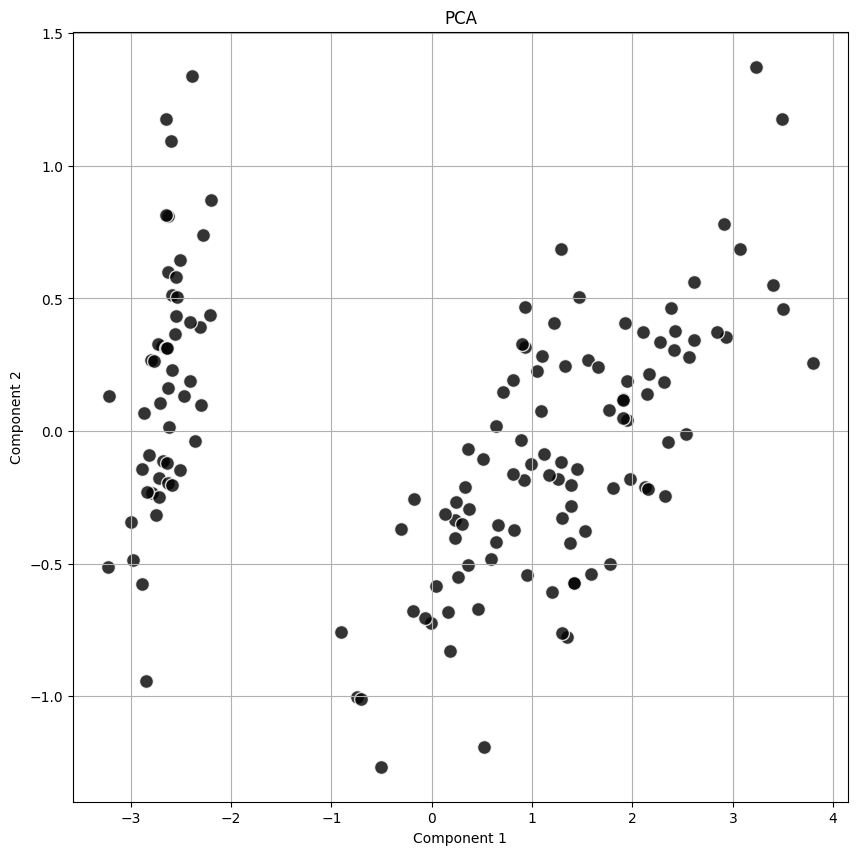

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iris = load_iris()
X = iris.data

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

components = ['Component_1', 'Component_2']
df_pca = pd.DataFrame(X_pca, columns=components)

plt.figure(figsize=(10, 10))
plt.scatter(df_pca['Component_1'], df_pca['Component_2'], alpha=0.8, edgecolors='w', s=100, c='k')
plt.title('PCA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid()
plt.show()


2.	Distribuid los datos en tres clústeres. Representadlos ahora con colores que indiquen el clúster al que pertenecen.

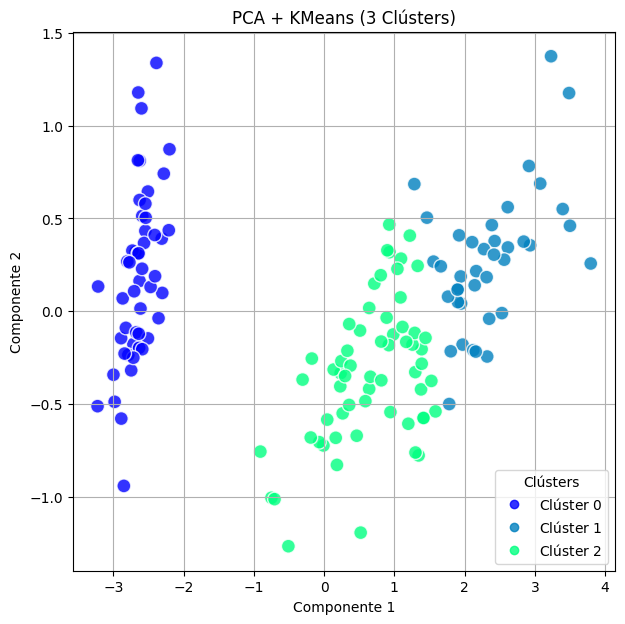

In [2]:
kmeans = KMeans(n_clusters=3, random_state=0, init='random', n_init=10, max_iter=300, tol=1e-04)
clusters = kmeans.fit_predict(X_pca)

df_pca['Cluster'] = clusters

plt.figure(figsize=(7, 7))
scatter = plt.scatter(df_pca['Component_1'], df_pca['Component_2'], 
                      alpha=0.8, edgecolors='w', s=100, 
                      c=df_pca['Cluster'], cmap='winter')
plt.title('PCA + KMeans (3 Clústers)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid()

handles, labels = scatter.legend_elements()

labels = [f'Clúster {label}' for label in labels]

plt.legend(handles, labels, title="Clústers", loc="best")
plt.show()

## B) Clústeting jerárquico

3. Representad el dendrograma del clustering jerárquico de los mismos datos obtenidos en la pregunta 1.

In [3]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
labels = ac.fit_predict(X)
print('Etiquetas de clústers: %s' % labels)

Etiquetas de clústers: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 2 0 2 0 2 2 2 2 0 2 0 2 2 0 2 0 2 0 0
 0 0 0 0 0 2 2 2 2 0 2 0 0 0 2 2 2 0 2 2 2 2 2 0 2 2 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


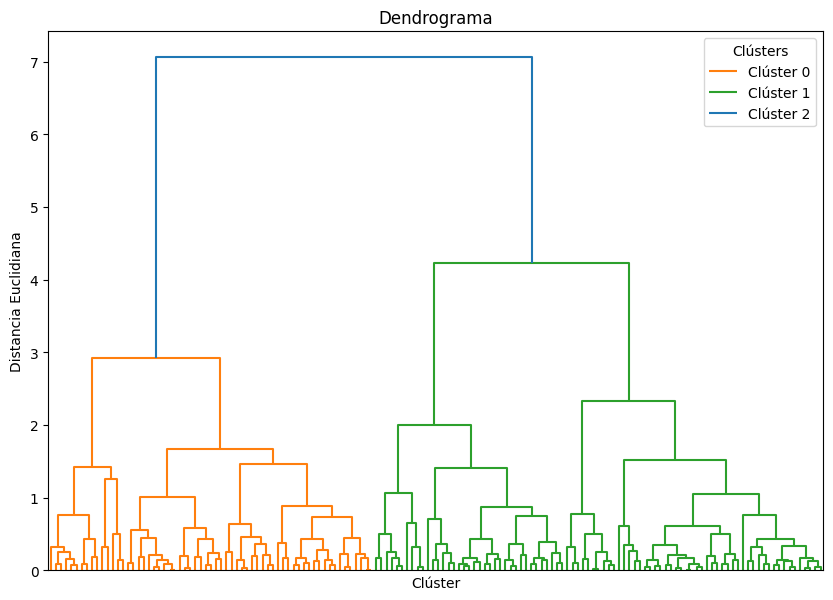

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked_cluster = linkage(X_pca, method='complete', metric='euclidean')
labels = ['Clúster 0', 'Clúster 1', 'Clúster 2']

plt.figure(figsize=(10, 7))
dendrogram(linked_cluster, orientation='top', distance_sort='ascending', show_leaf_counts=True)
plt.title('Dendrograma')
plt.xlabel('Clúster')
plt.ylabel('Distancia Euclidiana')
plt.legend(labels, title='Clústers', loc='best')

# He decidido no mostrar los ticks del eje x para que sea más legible
plt.xticks([])
plt.show()


## C) DBSCAN

4.	Aplicad el algoritmo de clustering DBSCAN a un conjunto de datos con forma de dos círculos concéntricos. Podéis guiaros con el siguiente ejemplo.

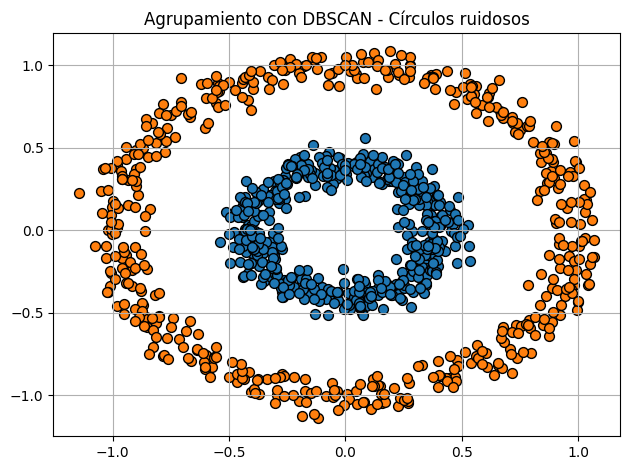

In [10]:
from sklearn.datasets import make_circles
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Generar datos circulares
X_circle, y_circle = make_circles(n_samples=1000, factor=0.4, noise=0.06, random_state=42)

# Configurar y aplicar DBSCAN
dbscan_model = DBSCAN(eps=0.25, min_samples=6)
clusters = dbscan_model.fit_predict(X_circle)

# Graficar los clusters detectados sin bucle
plt.scatter(X_circle[clusters == 0, 0], X_circle[clusters == 0, 1], edgecolor="k", s=50, label="Cluster 1")
plt.scatter(X_circle[clusters == 1, 0], X_circle[clusters == 1, 1], edgecolor="k", s=50, label="Cluster 2")

plt.title("Agrupamiento con DBSCAN - Círculos ruidosos")
plt.grid(visible=True)
plt.tight_layout()
plt.show()

### El algoritmo consigue separar los dos clústers, interior y exterior?

Como podemos ver, sí, el algoritmo DBSCAN consigue separar perfectamente los dos clústers.

## Cuantización de color

5. El clustering se puede aplicar al procesamiento de imágenes sustituyendo cada valor de color por el centroide más cercano. Si se utilizan muchos valores, la imagen procesada será una versión comprimida de la original que retendrá mucha fidelidad. A medida que se reduce el número de clústeres, la distorsión es más evidente a simple vista. En el caso extremo de considerar solo dos valores, estaríamos codificando cada píxel con solo un bit, lo cual se puede usar para codificar, por ejemplo, blanco y negro, dos tonos de gris o dos colores.

A partir de este código, obtén cuatro versiones comprimidas de una imagen de tu elección. Dos imágenes serán en escala de grises y dos en color. En dos de ellas usa un número elevado de clústeres y en la otra un número reducido. Puedes usar el código de los ejemplos siguientes.

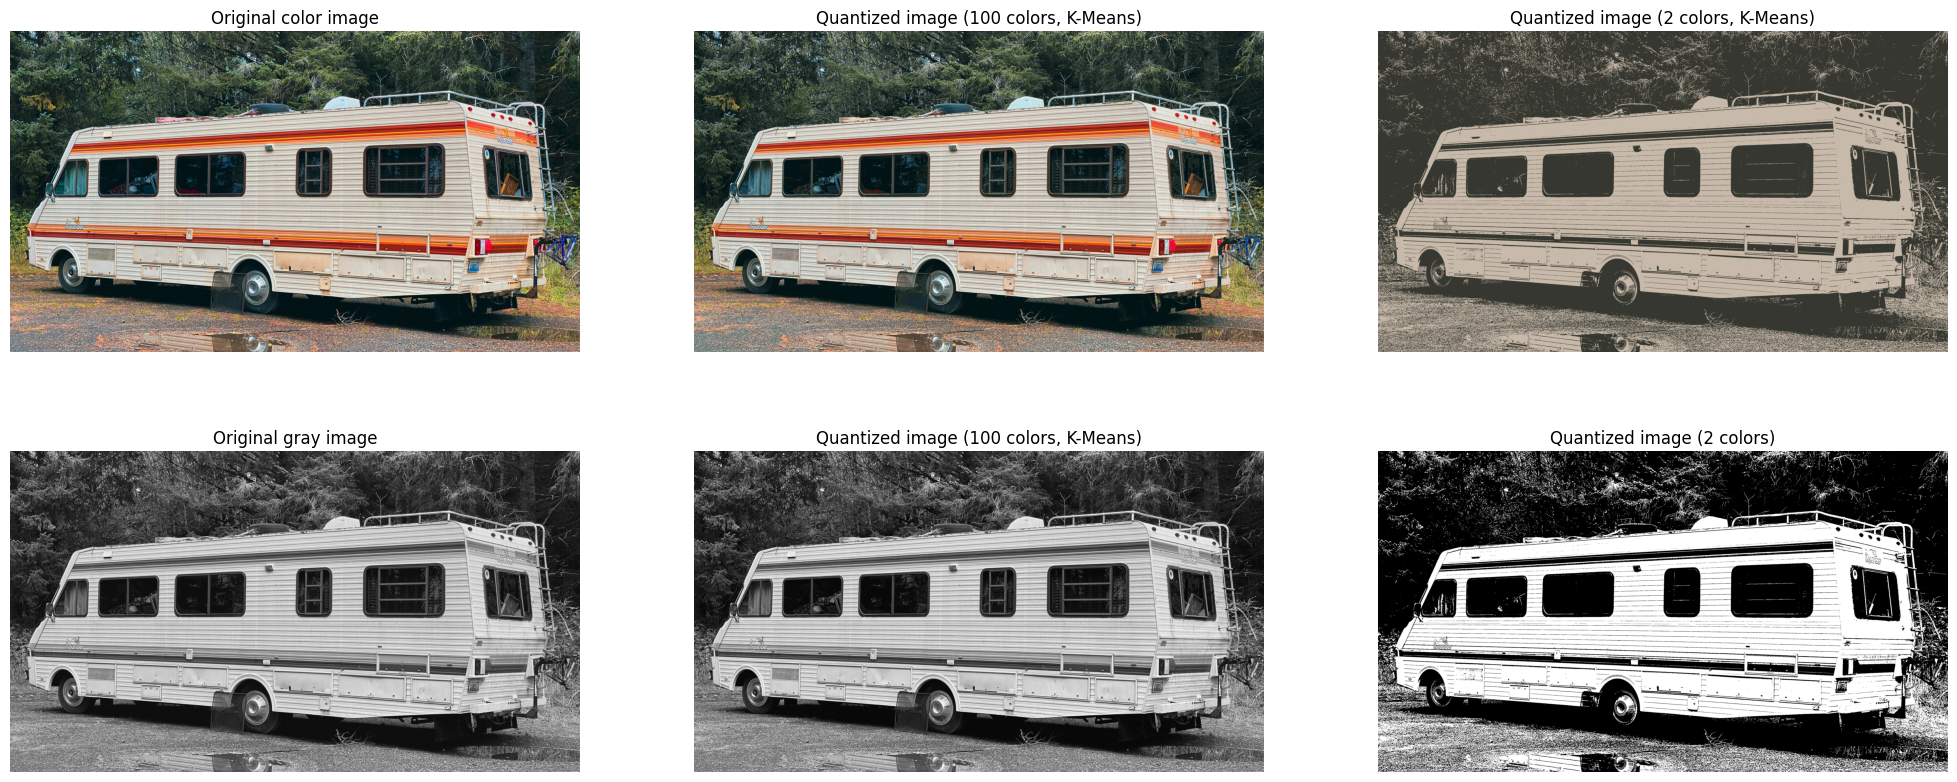

In [9]:
# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
from PIL import Image

from sklearn.cluster import KMeans

n_colors_many = 100
n_colors_few = 2

def recreate_image(codebook, labels, w, h):
    """Recrear la imagen (comprimida) a partir del libro de códigos y las etiquetas"""
    return codebook[labels].reshape(w, h, -1)

def clusterize_image(n_colors, image_array):
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array)
    labels = kmeans.predict(image_array)
    return kmeans, labels

image_url = 'https://images.unsplash.com/photo-1716354188820-8d917d680c4a?q=80&w=3132&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'

# Obtener la imagen desde la URL
response = requests.get(image_url)
custom_image = Image.open(BytesIO(response.content))

# Convierte la imagen a escala de grises
custom_gray_image = custom_image.convert("L")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow works well on float data (need to
# be in the range [0-1])

custom_gray_image = np.array(custom_gray_image, dtype=np.float64) / 255
custom_image = np.array(custom_image, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(custom_image.shape)
assert d == 3
image_array = np.reshape(custom_image, (w * h, d))
gray_image_array = np.reshape(custom_gray_image, (w * h, 1))
# KMeans con muchos colores
kmeans_many, labels_many = clusterize_image(n_colors_many, image_array)

# KMeans con pocos colores
kmeans_few, labels_few = clusterize_image(n_colors_few, image_array)

# # KMeans imagen escala de grises con muchos tonos
kmeans_gray_many, labels_gray_many = clusterize_image(n_colors_many, gray_image_array)

# # KMeans imagen escala de grises con pocos tonos
kmeans_gray_few, labels_gray_few = clusterize_image(n_colors_few, gray_image_array)

plt.figure(figsize=(25, 10))

# Imágenes en color
plt.subplot(2, 3, 1)
plt.axis("off")
plt.title("Original color image")
plt.imshow(custom_image)

plt.subplot(2, 3, 2)
plt.axis("off")
plt.title(f"Quantized image ({n_colors_many} colors, K-Means)")
plt.imshow(recreate_image(kmeans_many.cluster_centers_, labels_many, w, h))

plt.subplot(2, 3, 3)
plt.axis("off")
plt.title(f"Quantized image ({n_colors_few} colors, K-Means)")
plt.imshow(recreate_image(kmeans_few.cluster_centers_, labels_few, w, h))

# Imágenes escala de grises
plt.subplot(2, 3, 4)
plt.axis("off")
plt.title("Original gray image")
plt.imshow(custom_gray_image, cmap='gray')

plt.subplot(2, 3, 5)
plt.axis("off")
plt.title(f"Quantized image ({n_colors_many} colors, K-Means)")
plt.imshow(recreate_image(kmeans_gray_many.cluster_centers_, labels_gray_many, w, h), cmap='gray')

plt.subplot(2, 3, 6)
plt.axis("off")
plt.title(f"Quantized image ({n_colors_few} colors)")
plt.imshow(recreate_image(kmeans_gray_few.cluster_centers_, labels_gray_few, w, h), cmap='gray')
plt.show()